## TODO: Explain me!


In [1]:
!ls ../out # model picker

images                                softmax1-15m-2023_08_22_03_16_17
quantized                             softmax1-15m-2023_08_25_11_47_04
softmax0-15m-2023_08_22_14_44_50      softmax1-15m-2023_12_11_08_53_43-100k
softmax0-15m-2023_08_26_00_08_49      softmax1-15m-2023_12_11_08_53_43-70k
softmax0-15m-2023_12_11_10_05_14-100k softmax1-42m-2023_12_13_10_37_41
softmax0-15m-2023_12_11_10_05_14-70k


In [2]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os
import sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from tinystories import get_tokenizer_model_path  # noqa: E402
from tokenizer import Tokenizer  # noqa: E402
from model import ModelArgs, Transformer, softmax_sum  # noqa: E402


# -----------------------------------------------------------------------------
start = (
    ""  # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
)
max_new_tokens = 25  # number of tokens generated in each sample
temperature = (
    0  # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
)
top_k = (
    300  # retain only the top_k most likely tokens, clamp others to have 0 probability
)
tokenizer = ""  # override the tokenizer model path
seed = 1337
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
# dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False  # use PyTorch 2.0 to compile the model to be faster

softmax0_run = "softmax0-15m-2023_12_11_10_05_14-100k"
softmax1_run = "softmax1-42m-2023_12_13_10_37_41"
softmax1_110m_run = "artifacts/l83srejz_model:v49"
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
# for later use in torch.autocast
device_type = "cuda" if "cuda" in device else "cpu"
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)


def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    # del flash if exists
    if "flash" in checkpoint_dict["model_args"]:
        del checkpoint_dict["model_args"]["flash"]
    # softmax -> softmax1 in model_args
    if "softmax" in checkpoint_dict["model_args"]:
        checkpoint_dict["model_args"]["softmax1"] = checkpoint_dict["model_args"][
            "softmax"
        ]
        del checkpoint_dict["model_args"]["softmax"]
    gptconf = ModelArgs(**checkpoint_dict["model_args"])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict["model"]
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model)  # requires PyTorch 2.0 (optional)

    return model


def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", "r") as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config["vocab_size"]
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model="../tokenizer.model")
    return enc


model_softmax0 = load_model(f"../out/{softmax0_run}")
model_softmax1 = load_model(f"../out/{softmax1_run}")
# model_softmax1_110m = load_model(f"../{softmax1_110m_run}")

In [3]:
enc = load_tokenizer(f"../out/{softmax0_run}")


def encode_prompt(start):
    if start.startswith("FILE:"):
        with open(start[5:], "r", encoding="utf-8") as f:
            start = f.read()
    # Perhaps model sees EOS disproportionately used as BOS functionally (all except first in chunk)
    # So add EOS at start to fix EOS over-predicting
    start_ids = [enc.eos_id] + enc.encode(start, bos=False, eos=False)
    x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]
    return x


# run generation
@torch.no_grad()
def generate(
    prompt=start,
    model=model_softmax1,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_k=top_k,
    split_token=False,
    pbar=True,
):
    x = encode_prompt(prompt)
    with ctx:
        y = model.generate(x, max_new_tokens, temperature, top_k, pbar=pbar)
        if split_token:
            # print(y.tolist()[0])
            return [enc.decode([token]) for token in y.tolist()[0]]
        return enc.decode(y.tolist())[0]

In [4]:
# Really weird ... every tokenize(number) prepends invisible space. So tokenize("1") -> " 1"
enc.encode("1", eos=False, bos=False), generate(
    prompt="1", max_new_tokens=5, split_token=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 34.44it/s]


([29871, 29896], ['', '', '1', '0', 'years', 'old', ',', 'Jack'])

In [5]:
import torch.nn.functional as F


def compute_perplexity(
    prompt,
    model=model_softmax1,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_k=top_k,
):
    """
    Compute the perplexity given the logits of generated tokens and their corresponding indices.
    """
    x = encode_prompt(prompt)
    idx, logits = model.generate(
        x,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=top_k,
        return_logits=True,
    )
    probs = F.softmax(logits, dim=-1)
    actual_probs = torch.gather(probs, -1, idx.unsqueeze(-1)[:, x.shape[1] :, :])
    neg_log_probs = -torch.log(actual_probs)
    return torch.exp(torch.mean(neg_log_probs)).item()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from functools import partial


def attnsum_layer_heatmap(data, layer_num, ax, vmin=0, vmax=1.0, title_prefix=""):
    """
    Plot a heatmap for the specified layer's softmax attention score sums.

    Parameters:
    - data: 3D numpy array containing the attention scores.
    - layer_num: Layer number to plot.
    - ax: Matplotlib axis object to plot on.
    - vmin, vmax: Color scale limits.
    """
    ax.imshow(data[layer_num], aspect="auto", cmap="inferno", vmin=vmin, vmax=vmax)
    ax.set_title(f"{title_prefix} Sums Heatmap ({layer_num+1})")
    ax.set_ylabel("Attention Heads")
    ax.set_xlabel("Sequence")

    yrange = [str(n + 1) for n in np.arange(data[layer_num].shape[0])]

    ax.set_yticks(np.arange(len(yrange)))
    ax.set_yticklabels(yrange)
    ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)


def attnsum_layer_histogram(data, layer_num, ax):
    """
    Plot a histogram for the specified layer.

    Parameters:
    - data: 3D numpy array containing the attention scores.
    - layer_num: Layer number to plot.
    - ax: Matplotlib axis object to plot on.
    - bin_edges: Bin edges for the histogram.
    """
    ax.hist(
        data[layer_num].flatten(), bins=50, color="cornflowerblue", alpha=0.8, log=True
    )
    ax.set_title(f"Layer {layer_num+1} Attention Distribution")
    ax.set_xlabel("Attention Score Sum")
    ax.set_ylabel("Frequency (Log)")


def attnsum_layer(S, layer_num):
    """
    Wrapper function to plot both heatmap and histogram for a specified layer.

    Parameters:
    - layer_num: Layer number to plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot heatmap on the first axis
    attnsum_layer_heatmap(S, layer_num, axes[0])

    # Plot histogram on the second axis
    attnsum_layer_histogram(S, layer_num, axes[1])

    plt.tight_layout()
    plt.show()


def interactive_attnsum_layer(S):
    """
    Plot softmax1's attention score sums, per layer, interactively with iPython sliders.

    Parameters:
    - S (Tensor): Attention score sums.
    """
    # Create an interactive slider for layer selection
    layer_slider = widgets.IntSlider(
        value=0, min=0, max=S.shape[0] - 1, step=1, description="Layer Num:"
    )
    plot = widgets.interactive_output(
        partial(attnsum_layer, S), {"layer_num": layer_slider}
    )

    interactive_plot = widgets.VBox([layer_slider, plot])

    return interactive_plot


def rolling_window(data, window_size):
    """Apply a rolling window average to data."""
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, "valid")


def attnsum_all(softmax_data):
    """
    Plot a heatmap and histogram for the concatenated activations across all layers.

    Parameters:
    - softmax_data: 3D numpy array containing the activations.
    """
    # Concatenate activations along the attention heads dimension
    concat_activations = softmax_data.reshape(-1, softmax_data.shape[-1])
    num_heads = softmax_data.shape[1]

    # Min of activations over seq
    min_activations = torch.min(softmax_data, dim=1).values

    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 2)
    axes = [
        fig.add_subplot(gs[:, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 1]),
    ]

    # Plot heatmap for concatenated activations
    axes[0].imshow(concat_activations, aspect="auto", cmap="inferno")
    axes[0].set_title("Attention Score Sums")
    axes[0].set_ylabel("nth Attention Head of mth Block")
    axes[0].set_xlabel("Sequence Length")
    axes[0].figure.colorbar(mappable=axes[0].get_images()[0], ax=axes[0])

    # Plot histogram for all flattened values
    axes[1].hist(
        min_activations.flatten(), bins=15, color="cornflowerblue", edgecolor="black"
    )
    axes[1].set_title("Smallest Attention Score Sum over Sequence")
    axes[1].set_xlabel("Min Attention Score / Head / Layer")
    axes[1].set_ylabel("Frequency")

    # Find bottom 10% of mean values
    threshold = torch.quantile(concat_activations.mean(dim=1), 1)

    # Plot multiline plot for concatenated activations
    bottom_activations = []
    for i, line in enumerate(concat_activations):
        if line.mean() <= threshold:
            axes[2].plot(
                rolling_window(line.numpy(), 4),
                label=f"Head {i//num_heads} Layer {i%num_heads}",
                alpha=0.5,
            )
            bottom_activations.append(line)
    bottom_activations = torch.stack(bottom_activations)

    axes[2].plot(
        # Rolling window smoothens
        rolling_window(bottom_activations.mean(dim=0).numpy(), 4),
        label="Mean",
        color="black",
        linewidth=2,
    )

    axes[2].set_title("Attention Sum")
    axes[2].set_xlabel("Sequence Length")
    axes[2].set_ylabel("Attention Sum (Smoothened)")
    # axes[2].legend()

    plt.tight_layout()
    plt.show()

100%|██████████| 20/20 [00:00<00:00, 31.28it/s]


1+1+1+1+1+1=! She was so happy and proud of herself. But then, she realized that she had lost her
Perplexity: 1.6087


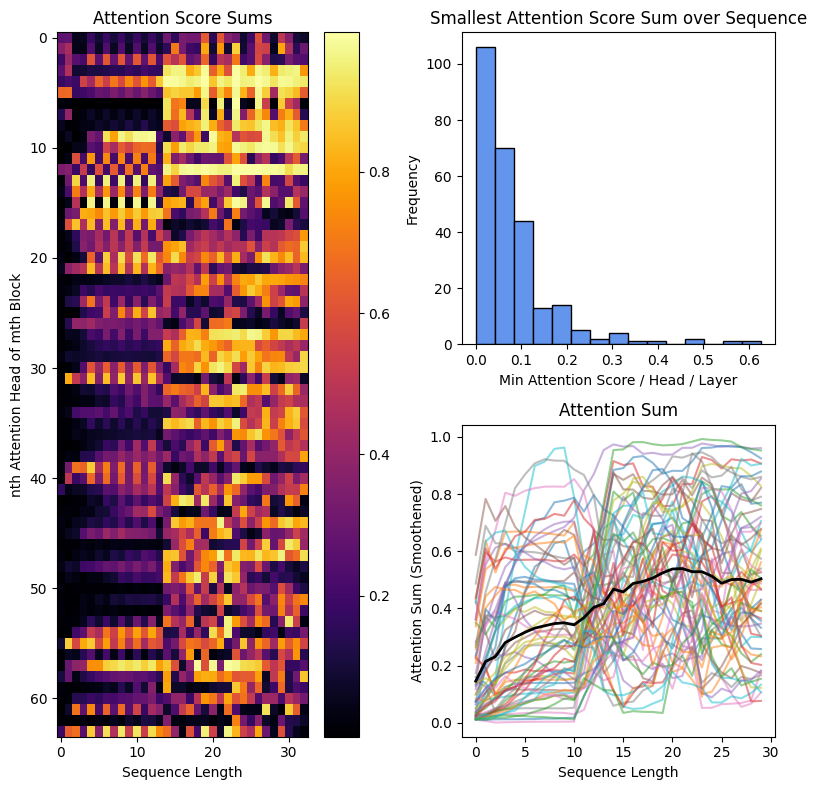

In [9]:
prompt = "1+1+1+1+1+1="
max_new_tokens = 20

model = model_softmax1
ppl = compute_perplexity(prompt, model=model, max_new_tokens=max_new_tokens)
print(generate(prompt=prompt, model=model, max_new_tokens=max_new_tokens))

S = model.compute_softmax_metrics()[0]

print(f"Perplexity: {ppl:.4f}")
# display(interactive_attnsum_layer(S))
attnsum_all(S)

In [10]:
def add_bias_to_attention_matrix(matrix):
    """
    Adds a bias token to the attention matrix.

    This function takes an attention matrix where the sums of attention
    weights are in the range 0-1 and adds an additional 'ghost' token to
    the start of the sequence to account for the unassigned attention
    (1-sum of weights).

    Parameters:
    - matrix (torch.Tensor): The original attention matrix without the bias token.

    Returns:
    - torch.Tensor: The extended attention matrix with the bias token added.
    """
    # Calculate the bias for each row (1 - sum of each row)
    bias = 1 - matrix.sum(axis=1)
    # Create an extended matrix with an additional row and column for the bias (ghost token)
    extended_matrix = np.zeros((matrix.size(0) + 1, matrix.size(1) + 1))
    # Copy the original attention matrix to the extended matrix (excluding the added row and column)
    extended_matrix[1:, 1:] = matrix
    # The bias (1 - sum) will be added as the first element (ghost token) of each row
    extended_matrix[1:, 0] = bias
    # The ghost token doesn't attend to anything so its attention is 0
    extended_matrix[0, :] = 0
    # The attention to the ghost token itself is set to 1
    extended_matrix[0, 0] = 1
    return extended_matrix


def plot_attention_heatmap(
    matrix,
    layer_idx,
    head_idx,
    token_sequence=None,
    ax=None,
    figsize=(9, 8),
    hide_bias=False,
    title_prefix="",
):
    """
    Plots a heatmap of the attention matrix.

    Given an extended attention matrix with a bias token, this function
    plots the heatmap with appropriate labels and color scales.

    Parameters:
    - matrix (np.ndarray): The extended attention matrix with the bias token.
    - layer_idx (int): The index of the layer for the title.
    - head_idx (int): The index of the head for the title.
    - token_sequence (list): The sequence of tokens for the axes.
    - ax (matplotlib.axes.Axes): The axis to plot on.
    - figsize (tuple): The figure size for the plot.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(matrix, cmap="inferno", aspect="equal")
    ax.figure.colorbar(mappable=ax.get_images()[0], ax=ax)

    # Enhancing the plot with titles and labels
    ax.set_title(
        f"'{' '.join(token_sequence)}'\n{title_prefix} Attention Matrix ({layer_idx+1}.{head_idx+1})"
    )
    ax.set_xlabel("Sequence Position")
    ax.set_ylabel("Sequence Position")
    ax.grid(False)

    bias = [] if hide_bias else ["Bias"]

    # Adjusting the tick labels to include the bias token
    x_labels = bias + list(range(matrix.shape[1] - 1))
    y_labels = bias + list(range(matrix.shape[0] - 1))

    if token_sequence:
        x_labels, y_labels = [bias + token_sequence] * 2

    # Setting the correct tick labels
    ax.set_xticks(ticks=np.arange(matrix.shape[1]))
    ax.set_xticklabels(x_labels, rotation=-90)
    ax.set_yticks(ticks=np.arange(matrix.shape[0]))
    ax.set_yticklabels(y_labels)

In [11]:
enc.decode(29871)

''

In [12]:
prompt = "Once upon a time, there was a old girl named"
max_new_tokens = 10

sum_arr = []
matrix_arr = []
seqs = []
for m in [model_softmax1]:
    completion = generate(
        model=m, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
    )
    print(f"Completion: {' '.join(completion)}")
    from model import softmax_sum, attn_matrices

    seqs.append(completion)
    sum_arr.append(torch.stack(softmax_sum))
    matrix_arr.append(torch.stack(attn_matrices))

print(seqs)

# Testing the functions by plotting the heatmap for Layer 1, Head 4 (index 3)


def plot(layer_index, head_index, hide_bias=True):
    fig, axs = plt.subplots(2, 2, figsize=(18, 16))

    layer_index -= 1
    head_index -= 1

    for i, (A, S, seq) in enumerate(zip(matrix_arr, sum_arr, seqs)):
        attnsum_layer_heatmap(
            data=S, layer_num=layer_index, ax=axs[0,
                                                  i], title_prefix=f"Softmax{i}"
        )

        attention_matrix = A[layer_index, head_index]
        extended_matrix = (
            attention_matrix
            if hide_bias
            else add_bias_to_attention_matrix(attention_matrix)
        )
        # Last output token (y[-1]) not included in attn matrix
        token_seq = seq[:-1]
        plot_attention_heatmap(
            extended_matrix,
            layer_index,
            head_index,
            token_seq,
            hide_bias=True,
            ax=axs[1, i],
            title_prefix=f"Softmax{i}",
        )


block = widgets.IntSlider(min=1, max=6, value=1)
head = widgets.IntSlider(min=1, max=6, value=1)

display(widgets.HBox([widgets.Label("Block"), block]))
display(widgets.HBox([widgets.Label("Head"), head]))
display(widgets.interactive_output(
    plot, {"layer_index": block, "head_index": head}))

100%|██████████| 10/10 [00:00<00:00, 39.85it/s]

Completion:  Once upon a time , there was a old girl named L ily . She loved to play outside in the
[['', 'Once', 'upon', 'a', 'time', ',', 'there', 'was', 'a', 'old', 'girl', 'named', 'L', 'ily', '.', 'She', 'loved', 'to', 'play', 'outside', 'in', 'the']]


Output()